In [53]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import xgboost as xgb
import pathlib

In [54]:
dataset_folder = os.path.join('D:/electro pi  scolership/task4/COVID-19_Radiography_Dataset/Normal')

In [55]:
dataset = pathlib.Path(dataset_folder)
images_dataset = list(dataset.glob("images/*.*"))[:5000]
masks_dataset = list(dataset.glob("masks/*.*"))[:5000]

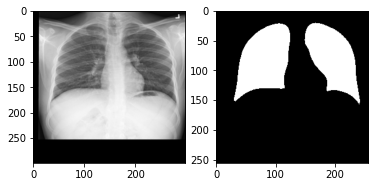

In [219]:
l = [images_dataset[4], masks_dataset[4]]
for i in range(2):
  plt.subplot(1, 2, i + 1)
  img  = cv2.imread(str(l[i]))
  plt.imshow(img)
plt.show()

# Preprocessing Dataset

In [220]:
def change_image_values(img):
  for i in range(48):
    for j in range(48):
      if img[i, j] <= 150:
        img[i, j] = 0
      elif img[i, j] > 150:
        img[i, j] = 1
  return img        

In [221]:
images = []
for i in images_dataset:
  img = cv2.imread(str(i))
  img = cv2.resize(img, (48, 48))
  images.append(img)
images = np.asarray(images) 
images.shape 

(5000, 48, 48, 3)

In [222]:
masks = []
for i in masks_dataset:
  img = cv2.imread(str(i), 0)
  img = cv2.resize(img.astype('uint8'), (48, 48), cv2.INTER_NEAREST)
  img = change_image_values(img)
  masks.append(img)
masks = np.array(masks) 
masks.shape   

(5000, 48, 48)

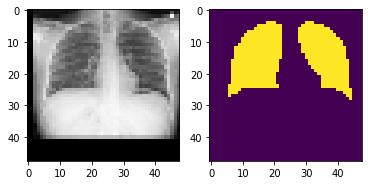

In [225]:
l = [images[4], masks[4]]
for i in range(2):
  plt.subplot(1, 2, i + 1)
  plt.imshow(l[i])
plt.show()

In [226]:
np.unique(masks[4])

array([0, 1], dtype=uint8)

VGG19 

In [71]:
model = tf.keras.applications.vgg19.VGG19(weights = "imagenet", include_top = False, 
                                          input_shape = (48, 48 , 3))
for i in model.layers:
  i.trainable = False

In [72]:
model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [73]:
new_model = tf.keras.models.Model(
    model.input, 
    model.get_layer("block1_conv2").output
)
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [75]:
features_images = new_model.predict(images, batch_size = 8)

In [76]:
features_images.shape

(5000, 48, 48, 64)

In [77]:
features_images[0,:,:,1].shape

(48, 48)

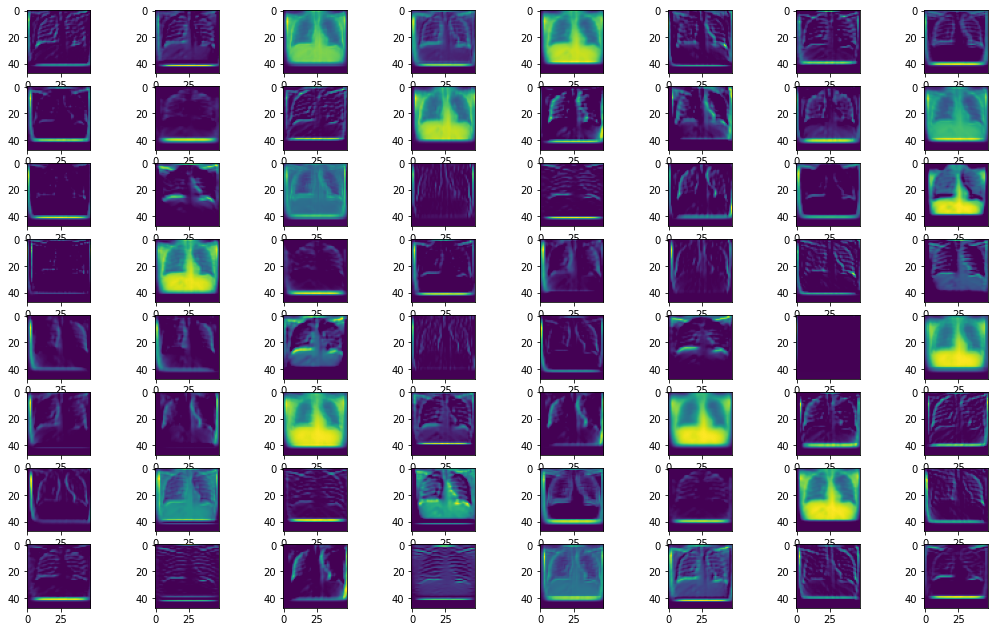

In [78]:
plt.figure(figsize = (18, 11))
counter = 1
for i in range(64):
  if counter == 65:
    break
  plt.subplot(8, 8, i + 1)
  plt.imshow(features_images[1,:,:,i])
  counter +=1
plt.show()  

In [79]:
x = features_images
x = x.reshape(-1, x.shape[3])

In [80]:
x.shape

(11520000, 64)

In [81]:
import pandas as pd
dataset = pd.DataFrame(x)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,55.220081,3.457926,0.142803,12.978667,37.766117,0.000000,0.0,3.522788,27.334770,0.0,...,60.528053,0.0,0.0,76.658394,0.0,0.0,6.237050,6.622620,68.935379,18.026709
1,0.000000,4.228812,9.710081,17.068233,73.434937,12.178363,0.0,1.451234,28.195734,0.0,...,104.756447,0.0,0.0,103.441261,0.0,0.0,15.303033,13.161977,5.727164,7.819905
2,14.040833,11.857573,7.756923,17.347858,64.908020,21.968052,0.0,2.775800,16.526314,0.0,...,93.884094,0.0,0.0,101.671043,0.0,0.0,7.631929,13.410709,5.179116,0.000000
3,3.944729,9.876775,7.481216,15.518068,62.930653,17.964018,0.0,1.272211,18.479101,0.0,...,91.691086,0.0,0.0,98.559647,0.0,0.0,7.930817,12.254296,8.826709,0.000000
4,1.915210,8.478022,7.238427,15.047607,61.681900,18.367249,0.0,1.430675,17.650194,0.0,...,88.847900,0.0,0.0,96.848434,0.0,0.0,7.774999,11.727070,8.301572,0.000000


In [82]:
y = masks
y = y.reshape(y.shape[0]*y.shape[1]*y.shape[2])
y.shape

(11520000,)

In [83]:
dataset['target'] = y

In [84]:
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,55.220081,3.457926,0.142803,12.978667,37.766117,0.000000,0.0,3.522788,27.334770,0.0,...,0.0,0.0,76.658394,0.0,0.0,6.237050,6.622620,68.935379,18.026709,0
1,0.000000,4.228812,9.710081,17.068233,73.434937,12.178363,0.0,1.451234,28.195734,0.0,...,0.0,0.0,103.441261,0.0,0.0,15.303033,13.161977,5.727164,7.819905,0
2,14.040833,11.857573,7.756923,17.347858,64.908020,21.968052,0.0,2.775800,16.526314,0.0,...,0.0,0.0,101.671043,0.0,0.0,7.631929,13.410709,5.179116,0.000000,0
3,3.944729,9.876775,7.481216,15.518068,62.930653,17.964018,0.0,1.272211,18.479101,0.0,...,0.0,0.0,98.559647,0.0,0.0,7.930817,12.254296,8.826709,0.000000,0
4,1.915210,8.478022,7.238427,15.047607,61.681900,18.367249,0.0,1.430675,17.650194,0.0,...,0.0,0.0,96.848434,0.0,0.0,7.774999,11.727070,8.301572,0.000000,0


In [85]:
features = dataset.drop(['target'], axis = 1)
target = dataset['target']

In [86]:
features.shape

(11520000, 64)

In [87]:
norm = tf.keras.layers.Normalization(input_shape = (64, ), axis = -1)
norm.adapt(features)

In [88]:
label = tf.keras.utils.to_categorical(target)

In [89]:
m = tf.keras.models.Sequential([
    norm,
    tf.keras.layers.Dense(512, activation = "tanh"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation = "softmax")
])
m.compile(loss = "binary_crossentropy", optimizer="adam", metrics=['accuracy'])
m.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 64)               129       
 n)                                                              
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 34,435
Trainable params: 34,306
Non-trainable params: 129
_________________________________________________________________


In [90]:
h = m.fit(features, label, epochs = 120, validation_split = 0.2, batch_size = 1024)

Epoch 1/120
9000/9000 [==============================] - 24s 3ms/step - loss: 0.1976 - accuracy: 0.9190 - val_loss: 0.1634 - val_accuracy: 0.9341
Epoch 2/120
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1721 - accuracy: 0.9299 - val_loss: 0.1529 - val_accuracy: 0.9387
Epoch 3/120
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1642 - accuracy: 0.9334 - val_loss: 0.1474 - val_accuracy: 0.9407
Epoch 4/120
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1598 - accuracy: 0.9351 - val_loss: 0.1441 - val_accuracy: 0.9422
Epoch 5/120
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1567 - accuracy: 0.9365 - val_loss: 0.1410 - val_accuracy: 0.9435
Epoch 6/120
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1544 - accuracy: 0.9375 - val_loss: 0.1397 - val_accuracy: 0.9441
Epoch 7/120
9000/9000 [==============================] - 22s 2ms/step - loss: 0.1526 - accuracy: 0.9382 - val_loss: 0.1380 -

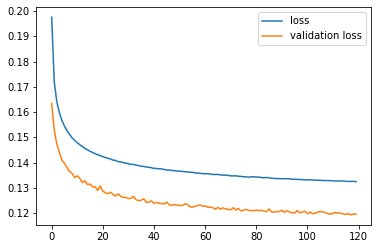

In [207]:
plt.plot(h.history['loss'], label = "loss")
plt.plot(h.history['val_loss'], label = "validation loss")
plt.legend()

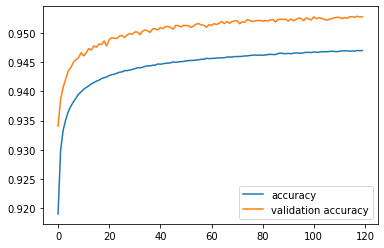

In [208]:
plt.plot(h.history['accuracy'], label = "accuracy")
plt.plot(h.history['val_accuracy'], label = "validation accuracy")
plt.legend()

In [209]:
m.evaluate(features, label)

360000/360000 [==============================] - 692s 2ms/step - loss: 0.1186 - accuracy: 0.9530


[0.11855198442935944, 0.9529631733894348]

#Test Model

In [229]:
def image_segmentation(img):
  img = np.reshape(img, (1, 48, 48, 3))
  features_img = new_model.predict(img)
  features_img = np.array(features_img)
  features_img = features_img.reshape(-1, features_img.shape[3])
  y_pred = m.predict(features_img)
  y_pred = np.array(y_pred)
  y_pred = np.argmax(y_pred, axis = 1)
  y_pred = y_pred.reshape(48, 48)
  return y_pred

In [214]:
def test_image(ind):
  img = images[ind]
  y_pred = image_segmentation(img)
  mask = masks[ind]
  list_fig = [img, mask, y_pred]
  list_title = ["orginal image", "orginal mask", "My Model"]
  plt.figure(figsize = (6, 8))
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(list_fig[i])
    plt.title(list_title[i])
  plt.show()  

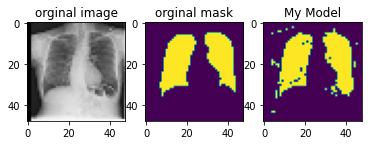

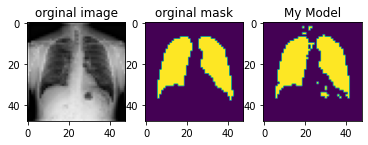

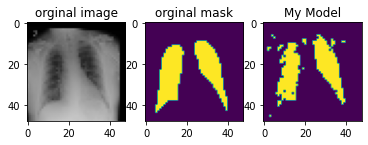

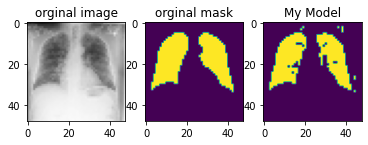

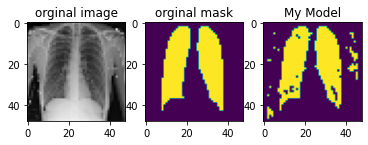

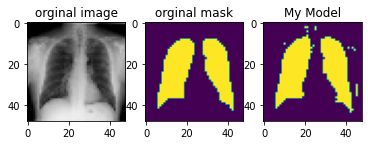

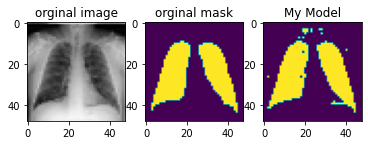

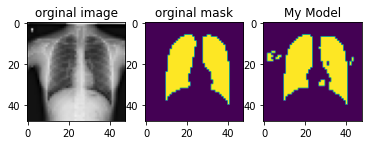

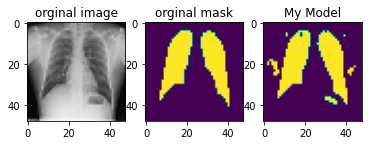

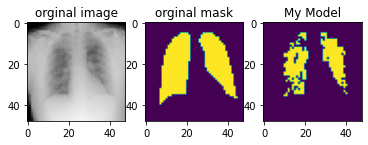

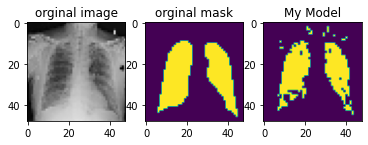

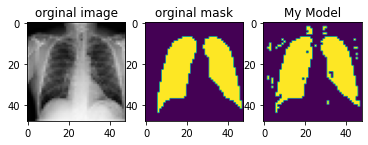

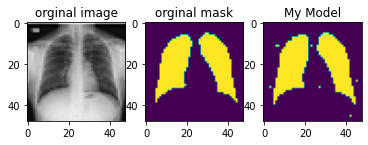

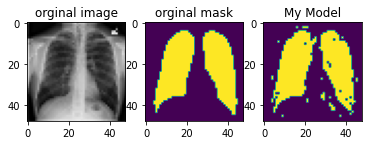

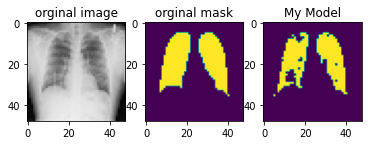

In [217]:
for i in range(20, 35):
  test_image(i)

In [ ]:
#comparison
VIT_b16	    30 epochs		91.7%
ResNet50	30 epochs		96%
Swin	    30 epochs	 	91.8%
ConvNext	50 epochs	    92.1%	
VGG19   	150 epochs		95.30%
